# Analysis of a sample from a Spanish renaissance choral corpus

Corpus:
* Cancionero de Medinaceli (https://cpage.mpr.gob.es/producto/cancionero-musical-de-la-casa-de-medinaceli-siglo-xvi-i-polifonia-profana-volumen-i/).

Selected works:

- 03_Lagrimas_de_mi_consuelo.mid
- 04_Por_ese_mar_d_Helesponto.mid
- 07_Puse_mis_amores.mid
- 08_A_bente_y_siete_de_marco.mid
- 09_Di_perra_mora.mid
- 11_Llaman_a_Teresica.mid
- 25_Cavallero_si_a_Francia_ides.mid
- 32_Pues_que_no_puedo_olvidarte.mid
- 40_Aquella_fuerca_grande.mid
- 42_Pues_que_me_tienes_Miguel.mid
- 44_Prado_verde_y_florido.mid
- 51_Corten_espadas_afiladas.mid
- 70_Huyd_huyd.mid

Sources:
* MIDI files: https://www.cpdl.org/wiki/index.php/Cancionero_de_Medinaceli

Select working directory

In [1]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import music21 as m21
import numpy as np
import glob
import os

path = os.path.join(os.path.expanduser('~'), 'Desktop', 'VIC', 'ChordIA-project-preparation')

if os.path.isdir(path):
    os.chdir(path)
else:
    raise FileNotFoundError(f"La carpeta no existe: {path}")

c:\Users\RUMBLE\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
c:\Users\RUMBLE\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=Tru

Find finalis of selected works except those transposed or absent in document (thus not possible to verify if finalis is correct).

In [2]:
all_finalis = []

for midi_path in glob.glob(os.path.join(path, 'input', 'cancionero_medinaceli','*.mid*')):
    # print(midi_path[84:])
    
    ####################### ToDo: transpose tonality of following files (not as in manuscript)
    if midi_path[84:] == '09_Di_perra_mora.mid':
        continue
    if midi_path[84:] == '32_Pues_que_no_puedo_olvidarte.mid':
        continue
    if midi_path[84:] == '42_Pues_que_me_tienes_Miguel.mid':
        continue
    if midi_path[84:] == '51_Corten_espadas_afiladas.mid':
        continue
    # Could not verify manuscript of this one:
    if midi_path[84:] == '70_Huyd_huyd.mid':
        continue

    score = m21.converter.parse(midi_path)
    # print(score.flat.notes[-1])
    
    # finalis = última nota
    if score.flat.notes[-1].isNote:
        finalis = score.flat.notes[-1].name
    elif score.flat.notes[-1].isChord:
        finalis = score.flat.notes[-1][-1].name

    # print('Finalis: ', finalis)
    all_finalis.append(finalis)

for f in set(all_finalis):
    print('Finalis =', f, ':', all_finalis.count(f))


Finalis = E : 1
Finalis = A : 2
Finalis = G : 3
Finalis = F : 1
Finalis = D : 1


Count and list chord types in one work (03_Lagrimas_de_mi_consuelo.mid)

In [3]:
midi_path = os.path.join(path, 'input', 'cancionero_medinaceli', '03_Lagrimas_de_mi_consuelo.mid')
score = m21.converter.parse(midi_path)

# Extract and analyze chords
chords = score.chordify()

prev_chord = []
all_commonnames = []
all_pitchnames = []
for c in chords.recurse().getElementsByClass('Chord'):
    # print(c.commonName, c.pitchNames)

    # Eliminate duplicated chords for stats
    if c.pitchNames == prev_chord:
        # print('SAME CHORD ---------------')
        continue
    else:
        all_commonnames.append(c.commonName)
        all_pitchnames.append(str(c.pitchNames))

    prev_chord = c.pitchNames

for name in set(all_commonnames):
    print(all_commonnames.count(name), name)


22 major triad
1 Major Third
6 quartal trichord
1 all-interval tetrachord
1 Minor Sixth with octave doublings
1 note
2 incomplete major-seventh chord
4 Perfect Fifth with octave doublings
4 Minor Third
1 Minor Third with octave doublings
1 half-diminished seventh chord
1 major-second minor tetrachord
2 Major Third with octave doublings
27 minor triad
1 major seventh chord


Histogram of the number of intervals by class per file:

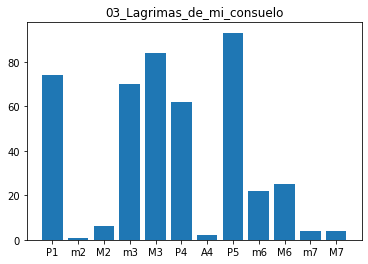

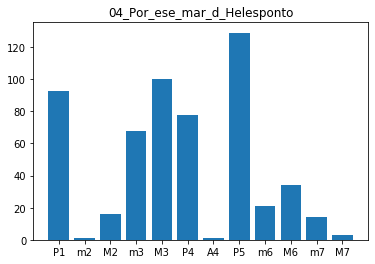

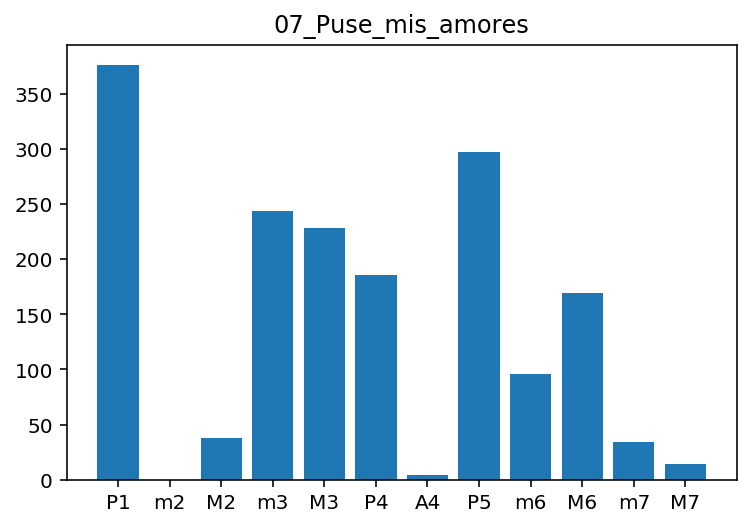

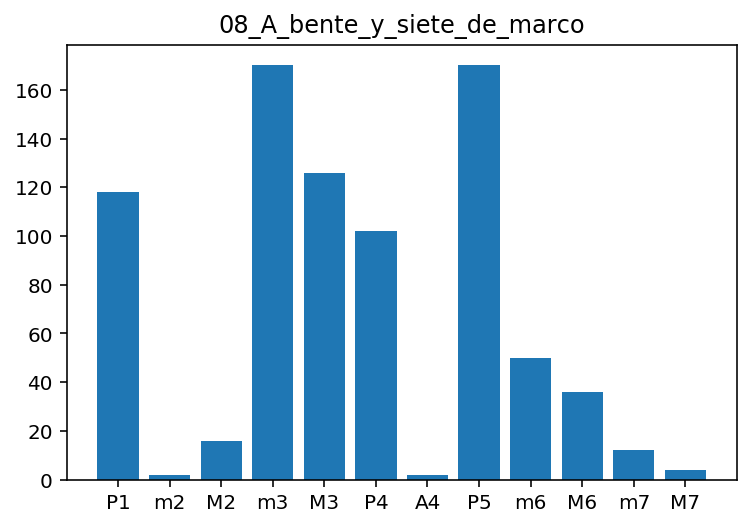

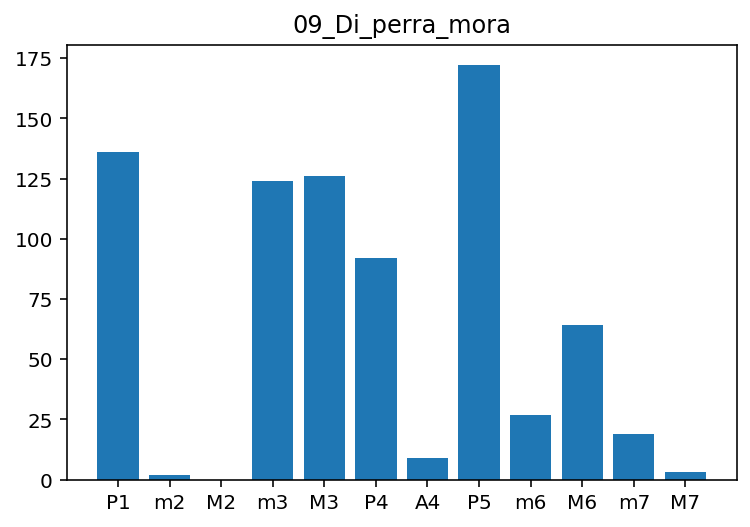

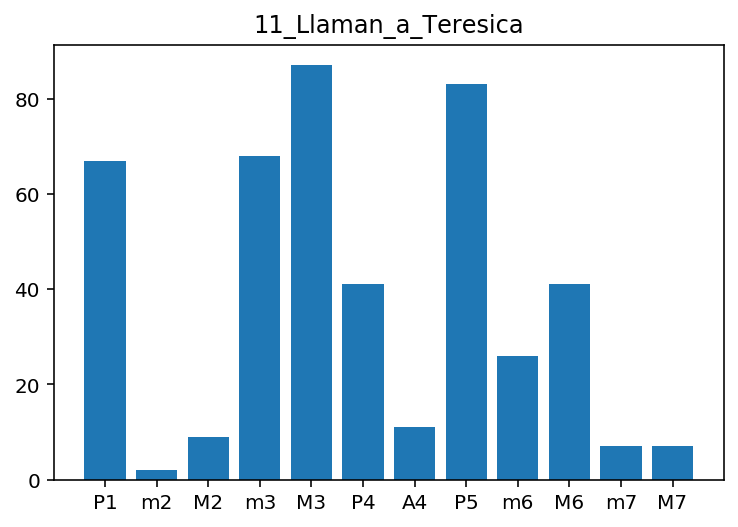

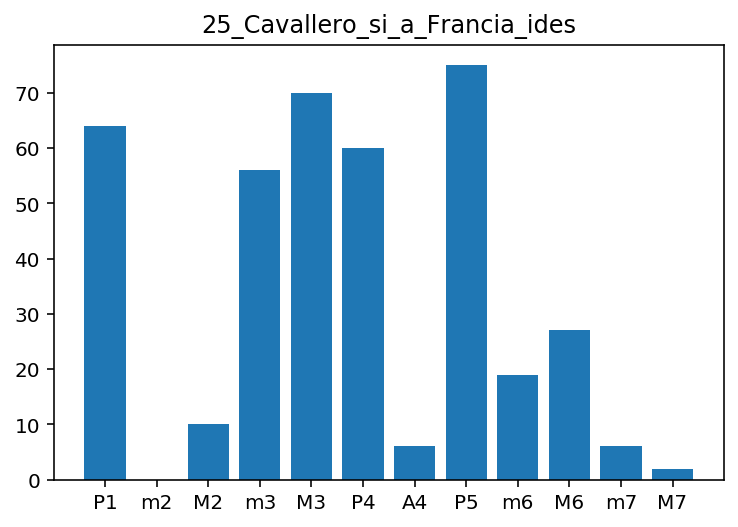

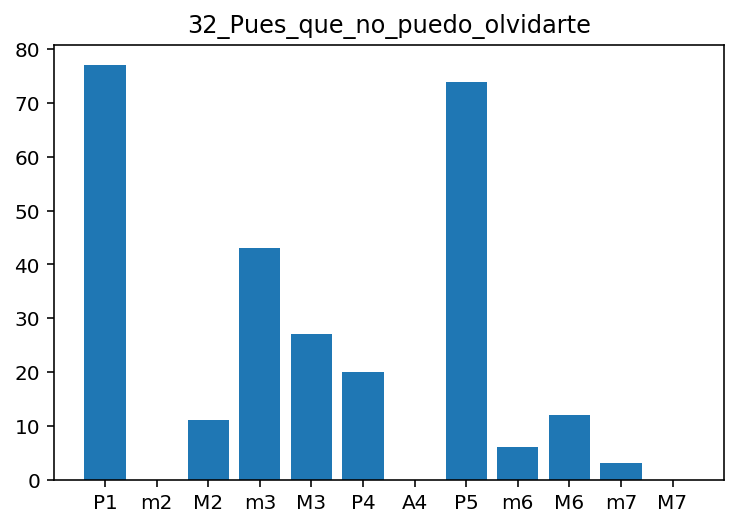

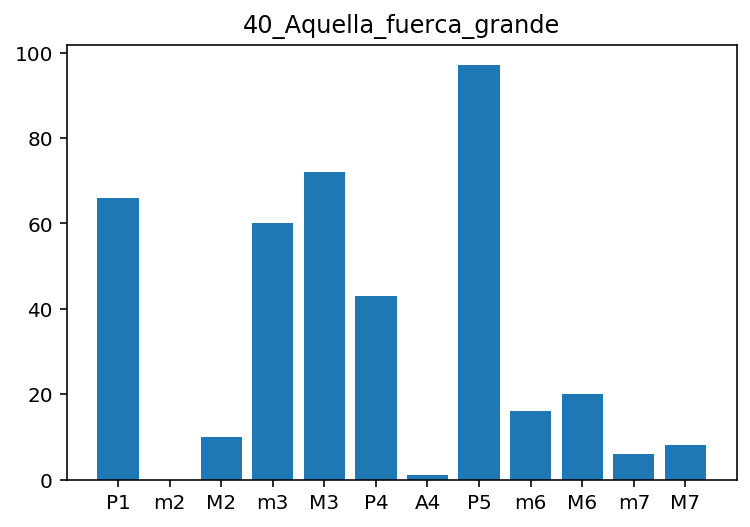

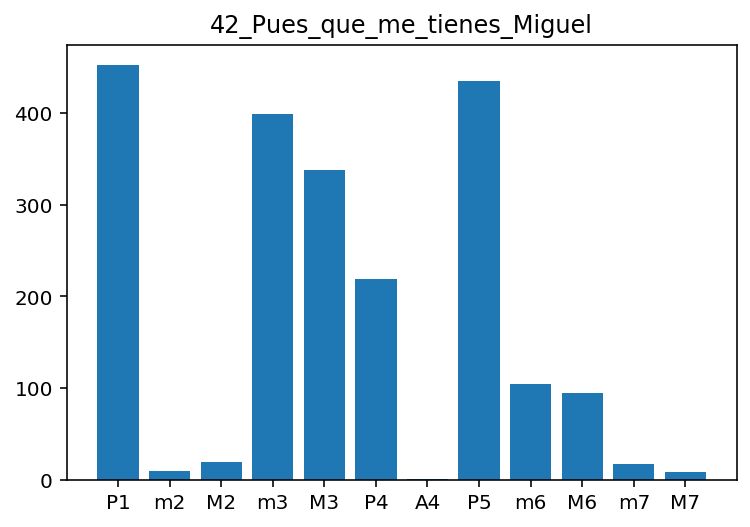

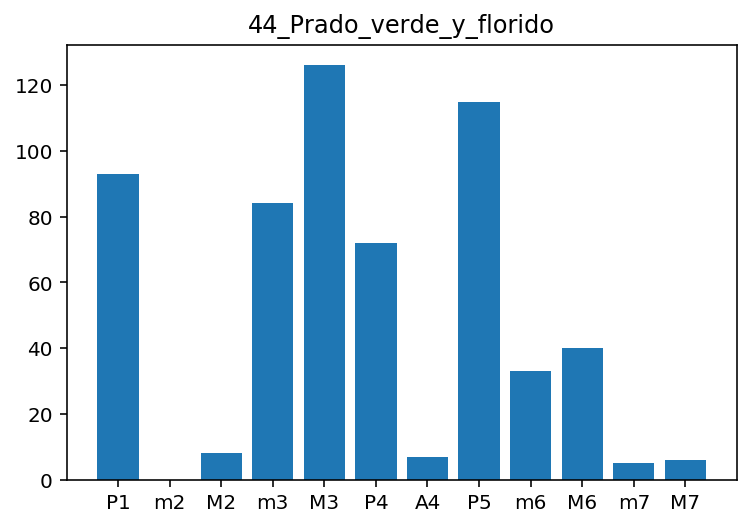

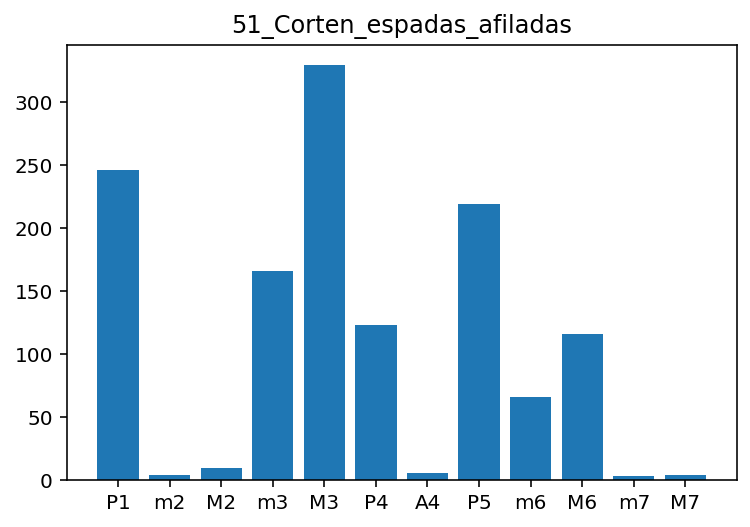

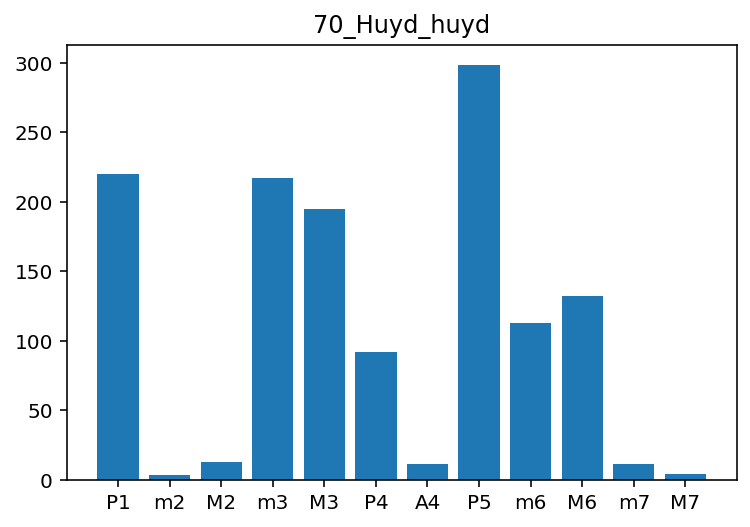

In [4]:
def interval_class_histogram(midi_path):
    score = m21.converter.parse(midi_path)
    chordified = score.chordify()

    # dict for histogram
    histogram = {}  # key: interval class (0–11), value: counter

    for element in chordified.recurse():
        if isinstance(element, m21.chord.Chord):
            pitches = element.pitches

            # if number of notes of the chord is at least 3
            if len(pitches) > 2:
                # Manual generation of pairs of notes of the chord
                for i in range(len(pitches)):
                    for j in range(i + 1, len(pitches)):
                        iv = m21.interval.Interval(pitches[i], pitches[j]).simpleName

                        # +1 for the corresponding interval class
                        if iv in histogram:
                            histogram[iv] += 1
                        else:
                            histogram[iv] = 1

    return histogram


# Plot histogram for each file
for midi_path in glob.glob(os.path.join(path, 'input', 'cancionero_medinaceli','*.mid*')):
    hist = interval_class_histogram(midi_path)
    interval_order = {
    0: "P1", 1: "m2", 2: "M2", 3: "m3", 4: "M3", 5: "P4",
    6: "A4", 7: "P5", 8: "m6", 9: "M6", 10: "m7", 11: "M7"
    }
    counts = [hist.get(name, 0) for name in interval_order.values()]
    labels = interval_order
    plt.figure()
    plt.bar(range(len(counts)), counts, width=0.8)
    plt.xticks(range(len(counts)), labels.values())
    plt.title(midi_path[84:-4])
    plt.show()



Group MIDI files by their similarity in terms of proportion of classes of chord intervals. All intervals weight the same.
  - Dendrogram (euclidean linkage).
  - 2-component PCA.

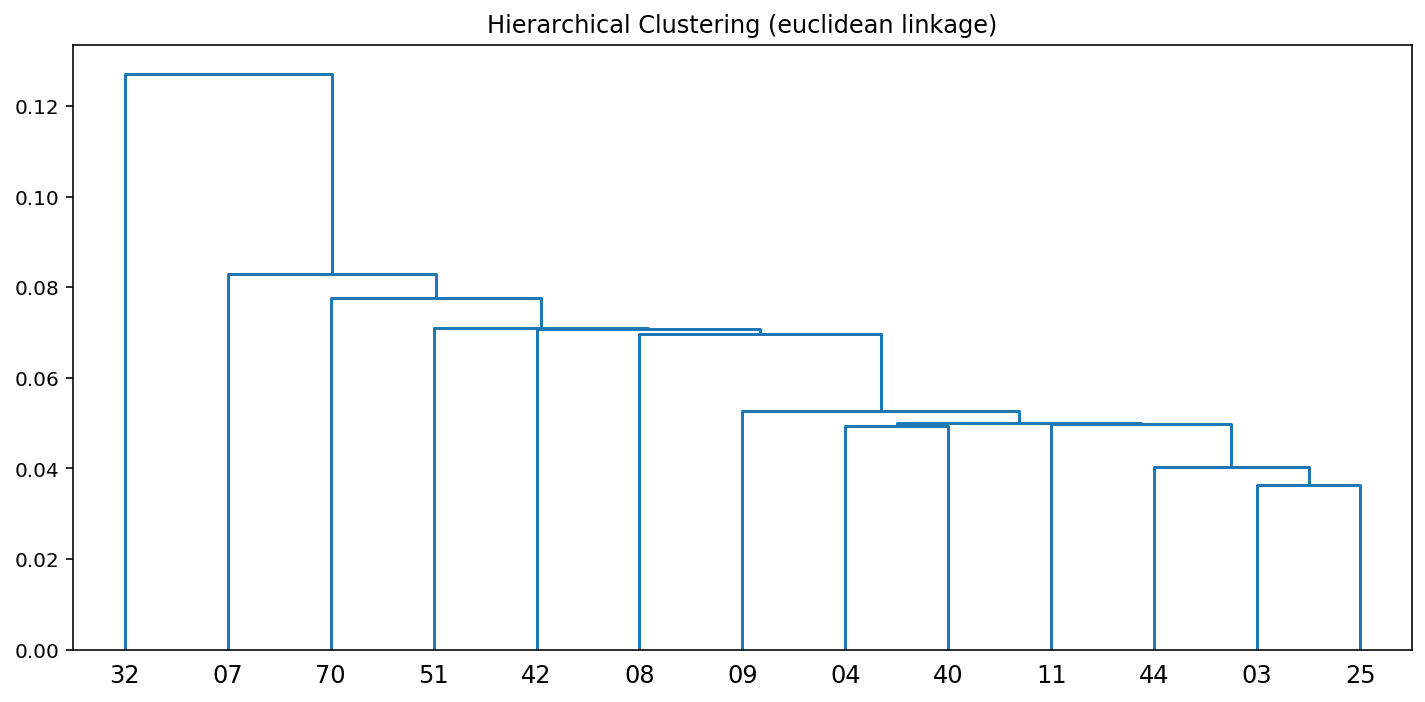

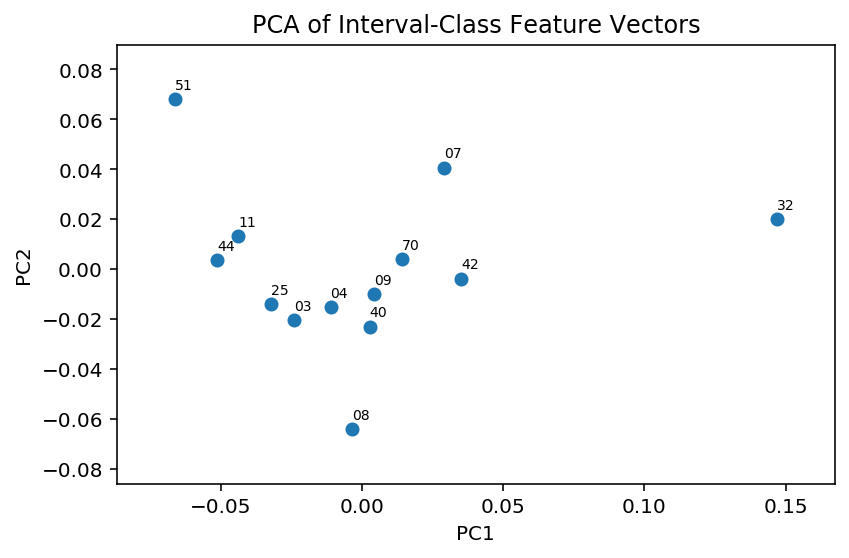

In [5]:
# Define interval order
interval_order = ["P1","m2","M2","m3","M3","P4","A4","P5","m6","M6","m7","M7"]
# Define folder path containing MIDI files
folder_path = os.path.join(path, 'input', 'cancionero_medinaceli')

def interval_vector(midi_path):
    """
    Creates an Interval-Class Feature Vector with 12 bins.
    Vector contains proportions of each class of interval (normalized to octave) present in chords of three or more notes.
    Number of intervals per type of chord:
      - 3-note chords: 3 intervals (1st note-2nd note, 2nd-3rd and 1st-3rd)
      - 4-note chords: 6 intervals (1-2, 2-3, 3-4, 1-3, 2-4, 1-4)
      - And so on
    """
    # Parse midi file
    score = m21.converter.parse(midi_path)
    # Reduce to chords
    chordified = score.chordify()

    # histogram: interval name → count
    hist = {}
    
    # parse chordified and class intervals into hist
    for elem in chordified.recurse():
        if isinstance(elem, m21.chord.Chord):
            pitches = elem.pitches
            if len(pitches) > 2: # triads or bigger chords
                for i in range(len(pitches)):
                    for j in range(i+1, len(pitches)):
                        iv = m21.interval.Interval(pitches[i], pitches[j])
                        iv_name = iv.simpleName
                        hist[iv_name] = hist.get(iv_name, 0) + 1

    # Build the 12D vector of intervals
    vec = np.array([hist.get(name, 0) for name in interval_order], dtype=float)

    # Normalize to proportions
    total = vec.sum()
    if total > 0:
        vec /= total

    return vec

def process_folder(folder_path):
    """
    Process set of MIDI files in folder_path and calculate Interval-Class Feature Vector for each file.
    
    Creates a matrix X of characteristics containing Interval-Class Feature Vector of all files. shape: (#pieces, 12):
      - Each row represents a MIDI file
      - Columns represent interval classes ordered from P1 to M7

    Returns
      - Matrix X
      - names: vector containing MIDI filenames ordered as in matrix X
    """
    # parse files in folder path, select only MIDI
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(".mid") or f.lower().endswith(".midi")]
    
    vectors = []
    names = []

    # Calculate Interval-Class Feature Vector for each file
    for f in files:
        vec = interval_vector(os.path.join(folder_path, f))
        vectors.append(vec)
        names.append(f)

    X = np.vstack(vectors)  # shape: (#pieces, 12)
    return X, names

def plot_hierarchical(X, names):
    Z = linkage(X, method='single')
    plt.figure(figsize=(10,5))
    dendrogram(Z, labels=names, color_threshold=0)
    plt.title("Hierarchical Clustering (euclidean linkage)")
    plt.tight_layout()
    plt.show()

def plot_pca(X, names, kmeans_show=True):
    pca = PCA(n_components=2)
    Y = pca.fit_transform(X)

    plt.figure()
    plt.scatter(Y[:,0], Y[:,1])

    for i, name in enumerate(names):
        plt.text(Y[i,0], Y[i,1]+0.004, name[:2], fontsize=7)

    plt.title("PCA of Interval-Class Feature Vectors")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

X, names = process_folder(folder_path)

plot_hierarchical(X, [name[:2] for name in names])
plot_pca(X, names)